---
title: "Variational Quantum Eigensolver (VQE) from scratch"
author: "Marcin Płodzień"
toc: true
number-sections: true
highlight-style: pygments
jupyter: python3
skip_showdoc: true
skip_exec: true
---

##  Finding ground state energy on NISQ devices

Finding a ground state energy of a quantum many-body system is one of the main objective in quantum physics. However, due to exponential increase of the Hilbert space with the number of particles the exact diagonalization methods fails. One of the possible way to overcome such a numerical restriction is to use Variational Quantum Eigensolver (VQE) on Near-Intermediate-Scale-Quantum (NISQ) devices.

The VQE is a variational method for finding ground state in quantum many-body system on a quantum computers with the help of automatic differentiation. It was first proposed in A. Peruzzo, et. al. [A variational eigenvalue solver on a photonic quantum processor](https://www.nature.com/articles/ncomms5213). The idea behind the VQE is to implement many-body wave-function ansatz as a parametrized quantum circuit. Next, the variational parameters optimization is prepared as a minimization of an expectation value of the considered Hamiltonian. For more details see our book [Modern applications of machine learning in quantum sciences](https://arxiv.org/pdf/2204.04198.pdf) p. 220. The schematic VQE protocol you can find below:

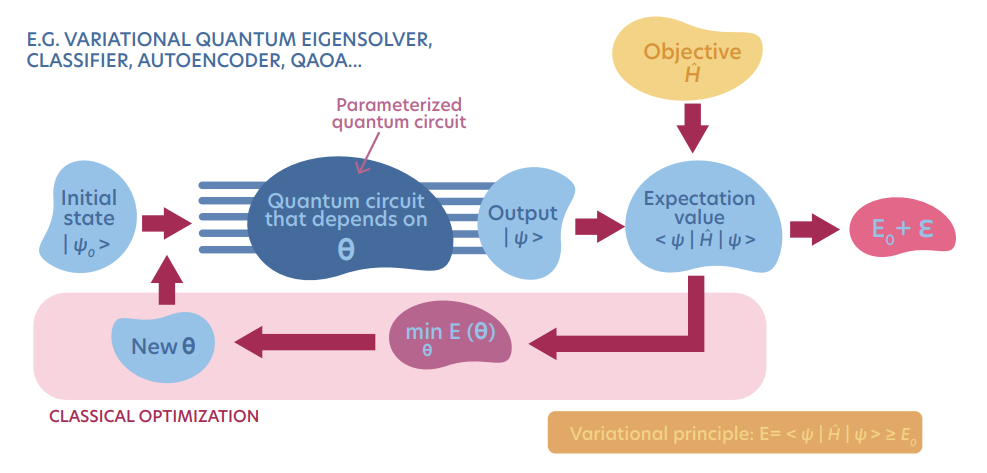

Let's implement a simple Variational Quantum Eigensolver for system containing $L=4$ spins-1/2 from scratch, using PyTorch automatic differentiation.
Let us consider $1D$ Hamiltonian:

\begin{equation}
 \hat{H} = \sum_{i}\sum_{\tau = x,y,z} J_\tau\hat{\sigma}^\tau_i\hat{\sigma}^\tau_{i+1} + \sum_i\sum_{\tau = x,y,z}h^\tau \hat{\sigma}^{\tau}_i,
\end{equation}
where $J_\tau$ and $h_\tau$ are Hamiltonian's parameters, and $\tau = x,y,z$.

Next, we have propose an ansatz in the form of a quantum circuit, schematically depicted on the figure below: 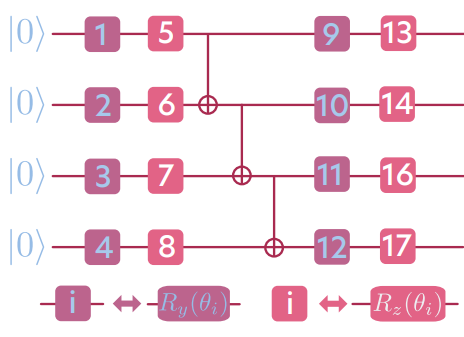

The above pictorial representation of the ansatz we denote as $|\psi(\vec{\theta})\rangle$. 
Our ansatz contains $3$ CNOT gates, and depends on $16$ angles $\theta_i$, $i \in (1,\dots,16)$ which parametrize the rotational gates defined as 
\begin{equation}
 \begin{split}
  R_y(\theta_i) & = e^{-i\theta_i \hat{\sigma}^y_i} \\
  R_z(\theta_i) & = e^{-i\theta_i \hat{\sigma}^z_i},
 \end{split}
\end{equation}
where $\hat{\sigma}^{\tau}$ are Pauli operators defined on a spin chain, i.e.
\begin{equation}
\hat{\sigma}^{\tau}_i = \mathbb{1}^{i-1}\otimes\hat{\sigma}_i\otimes\mathbb{1}^{N-i}.
\end{equation}
Here, the $\mathbb{1}$ is a $2\times2$ identity matrix, and $\hat{\sigma}^{\tau}$ are standard $2\times2$ Pauli matrices.


To find a ground state energy, or more precisiley, a set of parameters for which the expectation value of the Hamiltonian is smallest, we will minimize the energy of the system 
\begin{equation}
E(\vec{\theta}) = \langle \psi(\vec{\theta})|\hat{H}|\psi(\vec{\theta})\rangle
\end{equation}
via optimizing parameters $\vec{\theta}$. Optimization will be done via one of the optimization algorithms, such as SGD or Adam.

## Implementation:

Let's import all necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import torch as pt
from torch import matrix_exp as expm
from torch.linalg import eigh as eigh

Now, we implement spin-chain Pauli operators, rotational gates, and CNOT gates:

In [ ]:
def get_Identity(k):  # returns k-tensor product of the identity operator, ie. Id^k
    Id = id_local
    for i in range(0, k-1):
        Id = pt.kron(Id, id_local)
    return Id
         
def get_string_operator(A, L, i):
    Op = A
    if(i == 1):
        Op = pt.kron(A,get_Identity(L-1))
        return Op
    if(i == L):
        Op = pt.kron(get_Identity(L-1),A)
        return Op
    if(i>0 and i<L):
        Op = pt.kron(get_Identity(i-1), pt.kron(Op, get_Identity(L-i)))
        return Op
    
def Rx(theta, j):
    return expm(-1j*theta*sigma_x[j])

def Ry(theta, j):
    return expm(-1j*theta*sigma_y[j])

def Rz(theta, j):
    return expm(-1j*theta*sigma_z[j])    

def CNOT(i,j):
    return  expm(pt.pi/4*(Id - sigma_z[i])@(Id - sigma_x[j])*1j) 

Now, let's define system size and prepare necessary operators:

In [ ]:
L = 4    # Number of spins
D = 2**L # Size of the Hilbert space
# Pauli operators
id_local = pt.tensor([[1.,0],[0,1.]])  
sigma_x_local = pt.tensor([[0,1.],[1.,0]])  
sigma_y_local = 1j*pt.tensor([[0,-1.],[1.,0]]) 
sigma_z_local = pt.tensor([[1.,0],[0,-1.]])  

# Operators acting on j-th spin in spin chain
Id = get_string_operator(id_local, L, 1)
sigma_x = {}
sigma_y = {}
sigma_z = {}

for j in range(1,L+1):
    sigma_x[j] = get_string_operator(sigma_x_local, L, j)
    sigma_y[j] = get_string_operator(sigma_y_local, L, j)
    sigma_z[j] = get_string_operator(sigma_z_local, L, j)
    

Now, let us define our Hamiltonian and calculate its ground state energy with numerical diagonalization:

In [ ]:
# Hamiltonian parameters
J = {"x": 1.,
     "y": 1.,
     "z": -1.}
h = {"x": 1.,
     "y": 1.5,
     "z": 3.}

H = pt.zeros((D,D))
for i in range(1,L):
    H = H + J["x"]*sigma_x[i]@sigma_x[i+1] + J["y"]*sigma_y[i]@sigma_y[i+1] + J["z"]*sigma_z[i]@sigma_z[i+1]
for i in range(1,L+1):
    H = H + h["x"]*sigma_x[i] + h["y"]*sigma_y[i] + h["z"]*sigma_z[i]
    
    
E, P = eigh(H)
E_GS = E[0]
print('Exact ground state energy E_{GS} = ' + "{:2.2f}".format(E_GS))

Exact ground state energy E_{GS} = -16.11


We define our ansatz for the Hamiltonian ground state:

In [ ]:
def psi_ansatz(theta):   
    psi_re = pt.zeros(D)
    psi_im = pt.zeros(D)
    
    psi_re[D-1] = 1   # In computational basis this vector 
                      # corresponds to all spins down
    
    psi_tmp = pt.complex(psi_re,psi_im)    
    
    psi_tmp = Ry(theta[0],1)@psi_tmp
    psi_tmp = Ry(theta[1],2)@psi_tmp
    psi_tmp = Ry(theta[2],3)@psi_tmp
    psi_tmp = Ry(theta[3],4)@psi_tmp
 
    
    psi_tmp = Rz(theta[4],1)@psi_tmp
    psi_tmp = Rz(theta[5],2)@psi_tmp
    psi_tmp = Rz(theta[6],3)@psi_tmp
    psi_tmp = Rz(theta[7],4)@psi_tmp    
  
    

    psi_tmp = CNOT(1,2)@psi_tmp
    psi_tmp = CNOT(2,3)@psi_tmp
    psi_tmp = CNOT(3,4)@psi_tmp
    

    psi_tmp = Rz(theta[8],1)@psi_tmp
    psi_tmp = Rz(theta[9],2)@psi_tmp
    psi_tmp = Rz(theta[10],3)@psi_tmp
    psi_tmp = Rz(theta[11],4)@psi_tmp       
   
    
    psi_tmp = Ry(theta[12],1)@psi_tmp
    psi_tmp = Ry(theta[13],2)@psi_tmp
    psi_tmp = Ry(theta[14],3)@psi_tmp
    psi_tmp = Ry(theta[15],4)@psi_tmp

    return psi_tmp

Finally, we define our loss function as the expecation value of the Hamiltonian - function which we will minimize with the help of automatic differentiation, and optimization algorithms.

In [ ]:
def get_E(theta):
    psi_tmp = psi_ansatz(theta)
    E = pt.vdot(psi_tmp, H@psi_tmp)
    return E

In the last step, we initialize initial values of the theta as a torch tensor with trainable entries, and iteratively find optimal parameters $\vec{\theta}$:

/home/marcin/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'epoch')

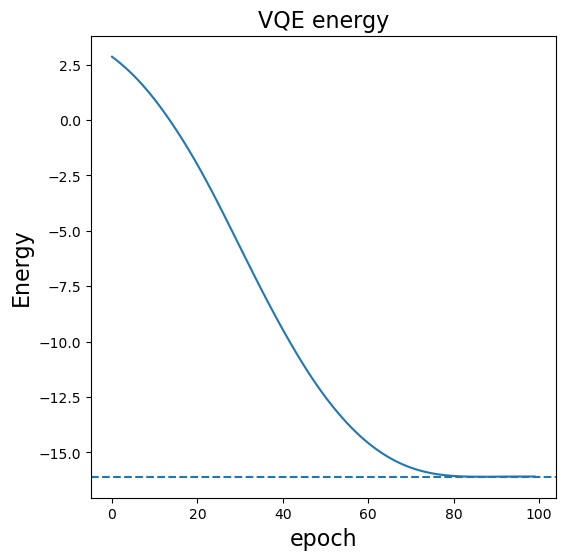

In [ ]:
theta = pt.zeros(16,requires_grad=True)
optimizer = pt.optim.Adam([theta],lr = 1e-2)

fig1, ax = plt.subplots(1,1, figsize=(6,6))
E_variational_vs_epochs = []
for i in range(0,100):
    loss = get_E(theta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    E_variational_vs_epochs.append(get_E(theta).item())

ax.plot(E_variational_vs_epochs)
ax.axhline(y=E_GS, linestyle = '--')
ax.set_title("VQE energy", fontsize = 16)
ax.set_ylabel("Energy", fontsize = 16)
ax.set_xlabel("epoch", fontsize = 16)

As we can see, the exact ground state energy (marked as a horizontal dashed line) and the expectation value of the optimized ansatz are in a very good agreement.